# Day 4 - Event Table EDA

This notebook performs exploratory data analysis on the user_events table to understand:
- Event type distribution
- Daily event trends
- Device type distribution
- Events per user patterns
- Early churn signals


## 1. Setup and Imports


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set data path
DATA_DIR = Path('data/raw')
EVENTS_FILE = DATA_DIR / 'user_events.csv'


## 2. Load Events Data


In [13]:
# Load events data in chunks (file may be large)
print(f"Loading events from: {EVENTS_FILE}")
print("This may take a while for large files...")

# First, get basic info about the file
chunk_size = 100000
chunks = []
total_rows = 0

for chunk in pd.read_csv(EVENTS_FILE, chunksize=chunk_size):
    chunks.append(chunk)
    total_rows += len(chunk)
    print(f"Loaded {total_rows:,} rows...")
    
    # For initial exploration, we can work with a sample
    # Uncomment the break to work with first chunk only for faster iteration
    # break

# Combine chunks
events = pd.concat(chunks, ignore_index=True)
print(f"\nTotal events loaded: {len(events):,}")

Loading events from: data/raw/user_events.csv
This may take a while for large files...
Loaded 100,000 rows...
Loaded 200,000 rows...
Loaded 300,000 rows...
Loaded 400,000 rows...
Loaded 500,000 rows...
Loaded 600,000 rows...
Loaded 700,000 rows...
Loaded 800,000 rows...
Loaded 900,000 rows...
Loaded 1,000,000 rows...
Loaded 1,100,000 rows...
Loaded 1,200,000 rows...
Loaded 1,300,000 rows...
Loaded 1,400,000 rows...
Loaded 1,500,000 rows...
Loaded 1,600,000 rows...
Loaded 1,700,000 rows...
Loaded 1,800,000 rows...
Loaded 1,900,000 rows...
Loaded 2,000,000 rows...
Loaded 2,100,000 rows...
Loaded 2,200,000 rows...
Loaded 2,300,000 rows...
Loaded 2,400,000 rows...
Loaded 2,500,000 rows...
Loaded 2,600,000 rows...
Loaded 2,700,000 rows...
Loaded 2,800,000 rows...
Loaded 2,900,000 rows...
Loaded 3,000,000 rows...
Loaded 3,100,000 rows...
Loaded 3,200,000 rows...
Loaded 3,300,000 rows...
Loaded 3,400,000 rows...
Loaded 3,500,000 rows...
Loaded 3,600,000 rows...
Loaded 3,700,000 rows...
Loaded

In [14]:
# Basic info about the dataset
print("Dataset Shape:", events.shape)
print("\nColumn Names:", events.columns.tolist())
print("\nData Types:")
print(events.dtypes)
print("\nFirst few rows:")
events.head()

Dataset Shape: (21406796, 5)

Column Names: ['user_id', 'event_type', 'event_time', 'device_type', 'page_url']

Data Types:
user_id        object
event_type     object
event_time     object
device_type    object
page_url       object
dtype: object

First few rows:


,user_id,event_type,event_time,device_type,page_url
0,2284-VFLKH,click,2023-01-01 00:00:19,desktop,/profile
1,8592-PLTMQ,watch,2023-01-01 00:00:38,mobile,/watch
2,4567-AKPIA,login,2023-01-01 00:00:46,mobile,/home
3,7426-GSWPO,login,2023-01-01 00:01:15,mobile,/login
4,1470-PSXNM,click,2023-01-01 00:01:23,mobile,/profile


In [15]:
# Check for null values
print("Null counts:")
null_counts = events.isnull().sum()
print(null_counts[null_counts > 0])

if null_counts.sum() == 0:
    print("\n✓ No null values found")


Null counts:
Series([], dtype: int64)

✓ No null values found


In [16]:
# Convert event_time to datetime
events['event_time'] = pd.to_datetime(events['event_time'])
print("Event time range:")
print(f"  Earliest: {events['event_time'].min()}")
print(f"  Latest: {events['event_time'].max()}")


Event time range:
  Earliest: 2023-01-01 00:00:19
  Latest: 2025-12-30 23:01:40


## 3. Event Type Distribution


In [17]:
# Event type distribution
event_type_counts = events['event_type'].value_counts()
event_type_pct = events['event_type'].value_counts(normalize=True) * 100

print("Event Type Distribution:")
print("=" * 50)
for event_type, count in event_type_counts.items():
    pct = event_type_pct[event_type]
    print(f"{event_type:15s}: {count:>10,} ({pct:>5.2f}%)")

print(f"\nTotal events: {len(events):,}")


Event Type Distribution:
login          :  8,310,599 (38.82%)
watch          :  7,748,810 (36.20%)
click          :  5,159,197 (24.10%)
cancel         :    188,190 ( 0.88%)

Total events: 21,406,796


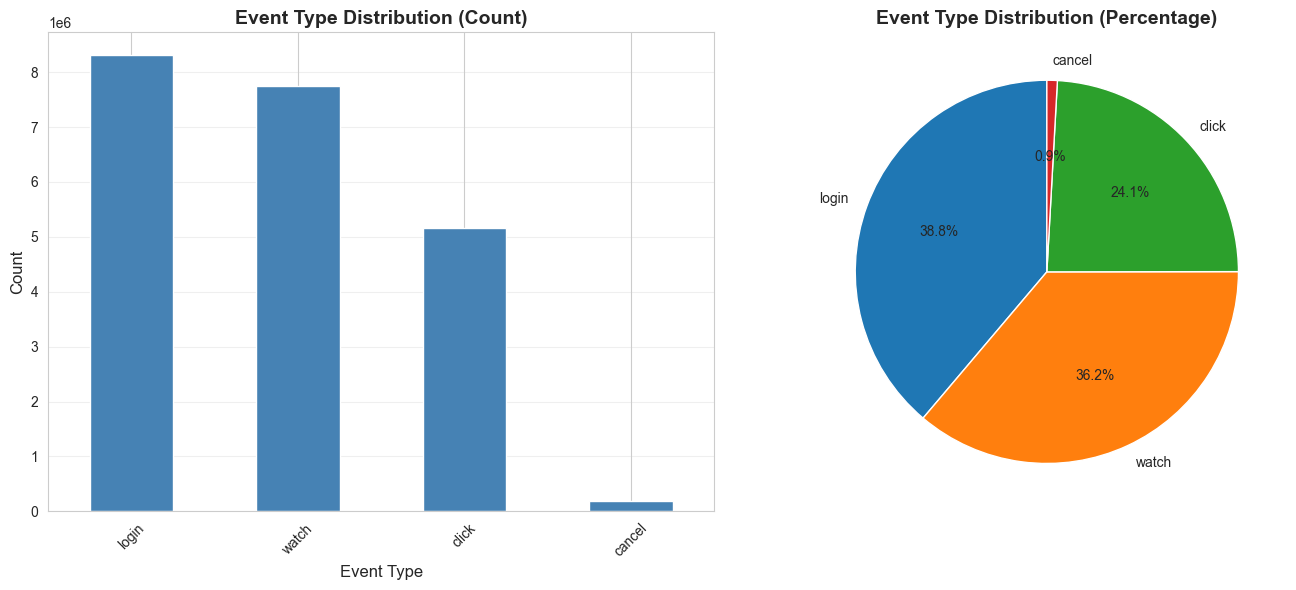

In [18]:
# Visualize event type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
event_type_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Event Type Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Event Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
event_type_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Event Type Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


## 4. Daily Event Trend


In [19]:
# Aggregate events by date
events['date'] = events['event_time'].dt.date
daily_events = events.groupby('date').size().reset_index(name='event_count')
daily_events['date'] = pd.to_datetime(daily_events['date'])
daily_events = daily_events.sort_values('date')

print("Daily Event Summary:")
print(f"  Date range: {daily_events['date'].min()} to {daily_events['date'].max()}")
print(f"  Total days: {len(daily_events)}")
print(f"  Average events per day: {daily_events['event_count'].mean():,.0f}")
print(f"  Min events per day: {daily_events['event_count'].min():,}")
print(f"  Max events per day: {daily_events['event_count'].max():,}")


Daily Event Summary:
  Date range: 2023-01-01 00:00:00 to 2025-12-30 00:00:00
  Total days: 1095
  Average events per day: 19,550
  Min events per day: 13,911
  Max events per day: 21,654


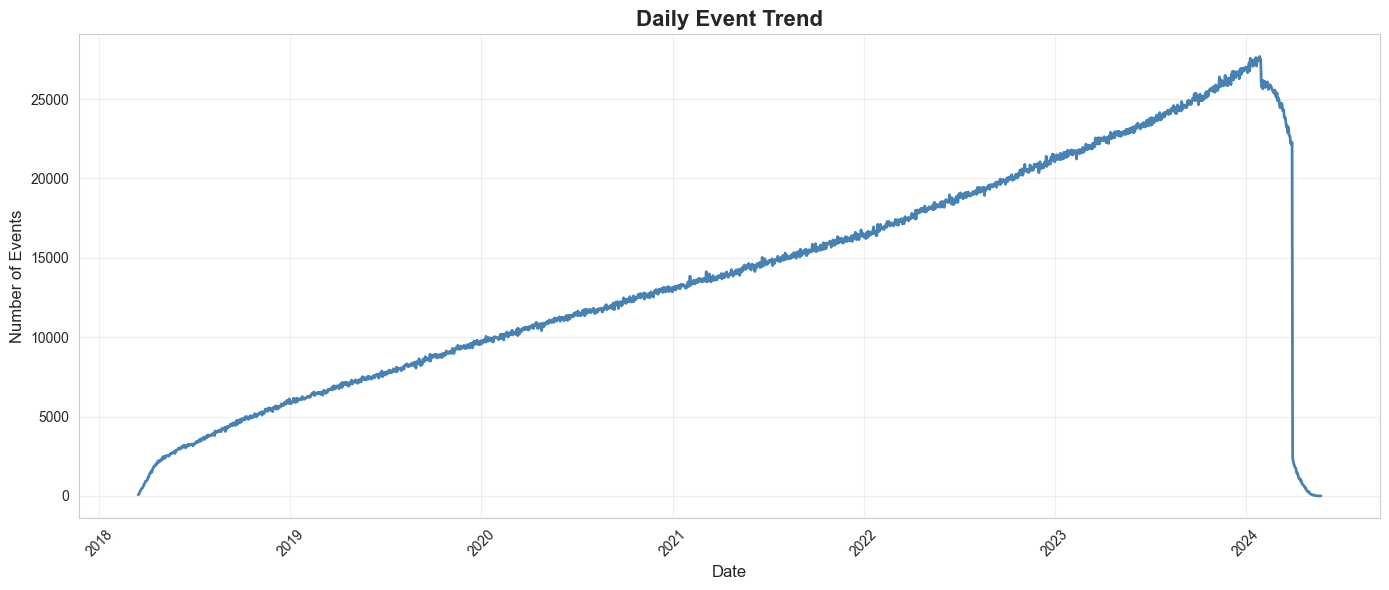

In [9]:
# Plot daily event trend
plt.figure(figsize=(14, 6))
plt.plot(daily_events['date'], daily_events['event_count'], linewidth=2, color='steelblue')
plt.title('Daily Event Trend', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


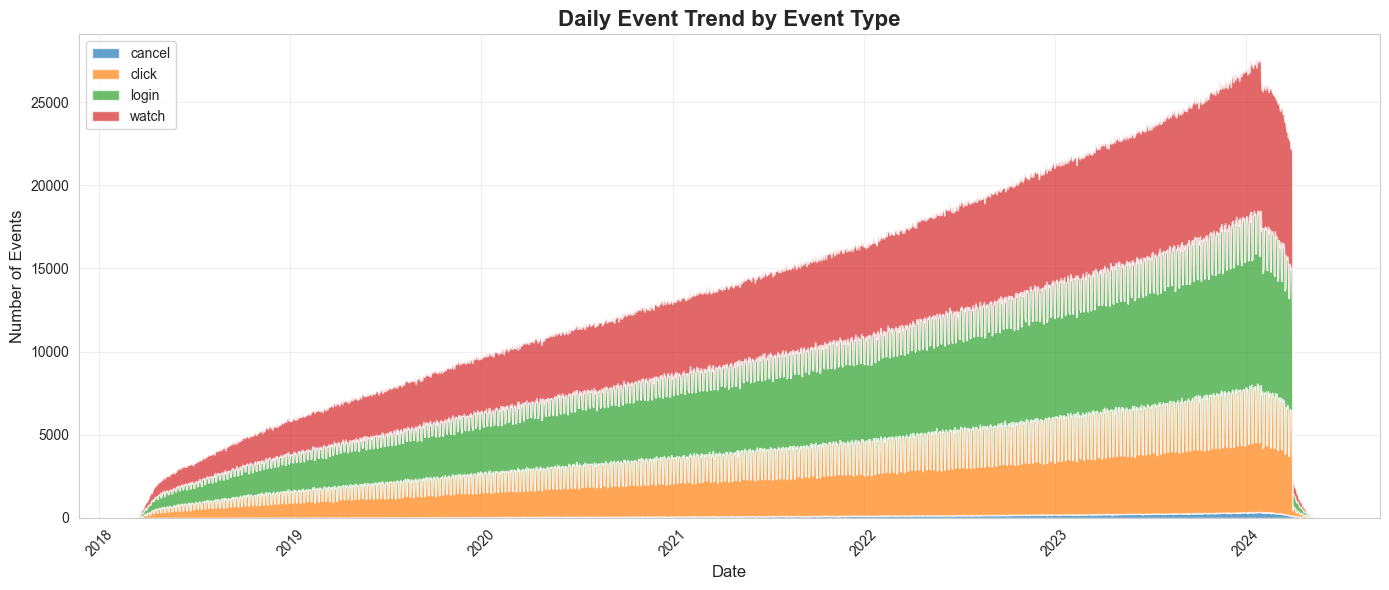

In [10]:
# Daily events by event type
events['date'] = events['event_time'].dt.date
daily_by_type = events.groupby(['date', 'event_type']).size().reset_index(name='count')
daily_by_type['date'] = pd.to_datetime(daily_by_type['date'])
daily_by_type = daily_by_type.sort_values('date')

# Pivot for easier plotting
daily_pivot = daily_by_type.pivot(index='date', columns='event_type', values='count').fillna(0)

# Plot stacked area chart
plt.figure(figsize=(14, 6))
plt.stackplot(daily_pivot.index, *[daily_pivot[col] for col in daily_pivot.columns], 
               labels=daily_pivot.columns, alpha=0.7)
plt.title('Daily Event Trend by Event Type', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Device Type Distribution


In [20]:
# Device type distribution
device_counts = events['device_type'].value_counts()
device_pct = events['device_type'].value_counts(normalize=True) * 100

print("Device Type Distribution:")
print("=" * 50)
for device_type, count in device_counts.items():
    pct = device_pct[device_type]
    print(f"{device_type:15s}: {count:>10,} ({pct:>5.2f}%)")

print(f"\nTotal events: {len(events):,}")


Device Type Distribution:
mobile         : 12,873,638 (60.14%)
desktop        :  7,338,435 (34.28%)
tablet         :  1,087,690 ( 5.08%)
unknown        :    107,033 ( 0.50%)

Total events: 21,406,796


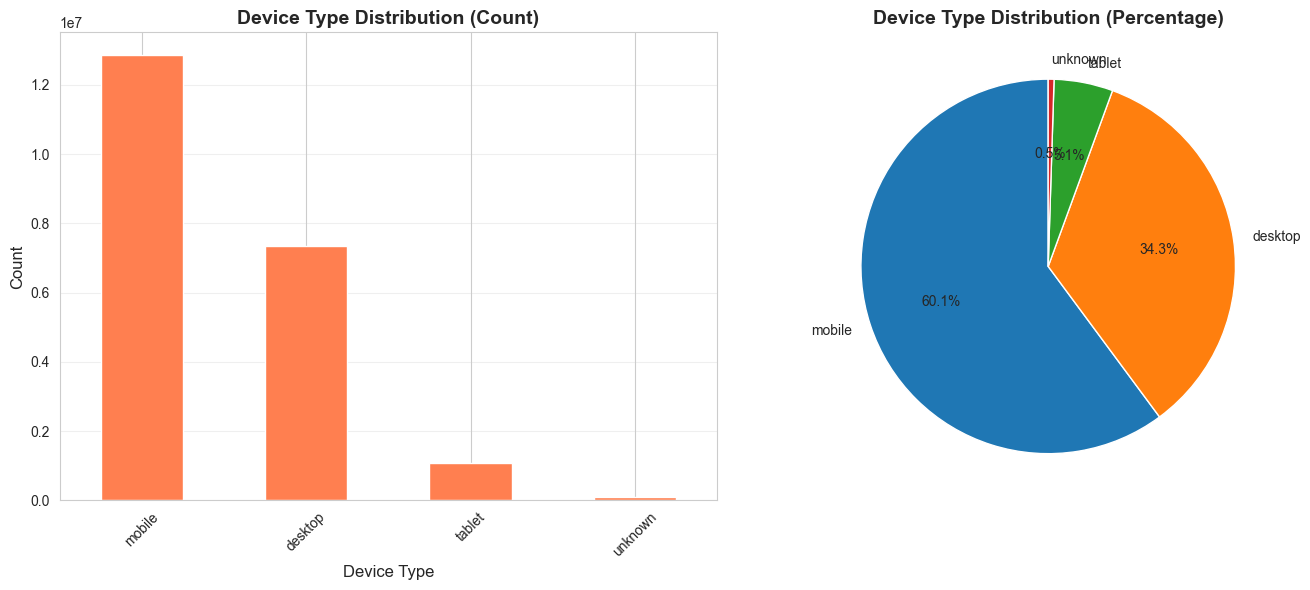

In [21]:
# Visualize device type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
device_counts.plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('Device Type Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Device Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
device_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Device Type Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [22]:
# Device type by event type (cross-tabulation)
device_event_crosstab = pd.crosstab(events['device_type'], events['event_type'], margins=True)
print("Device Type × Event Type Cross-tabulation:")
print("=" * 60)
print(device_event_crosstab)

Device Type × Event Type Cross-tabulation:
event_type   cancel    click    login    watch       All
device_type                                             
desktop       67724  1769185  2848009  2653517   7338435
mobile       111127  3101033  4997124  4664354  12873638
tablet         8458   263163   424052   392017   1087690
unknown         881    25816    41414    38922    107033
All          188190  5159197  8310599  7748810  21406796


## 6. Events per User


In [23]:
# Calculate events per user
events_per_user = events.groupby('user_id').size().reset_index(name='event_count')

print("Events per User Statistics:")
print("=" * 50)
print(events_per_user['event_count'].describe())
print(f"\nTotal unique users: {len(events_per_user):,}")
print(f"Users with zero events: {len(events_per_user[events_per_user['event_count'] == 0]):,}")
print(f"Users with 1+ events: {len(events_per_user[events_per_user['event_count'] > 0]):,}")


Events per User Statistics:
count     7037.000000
mean      3042.034390
std       2354.966051
min          4.000000
25%        907.000000
50%       2628.000000
75%       5124.000000
max      20498.000000
Name: event_count, dtype: float64

Total unique users: 7,037
Users with zero events: 0
Users with 1+ events: 7,037


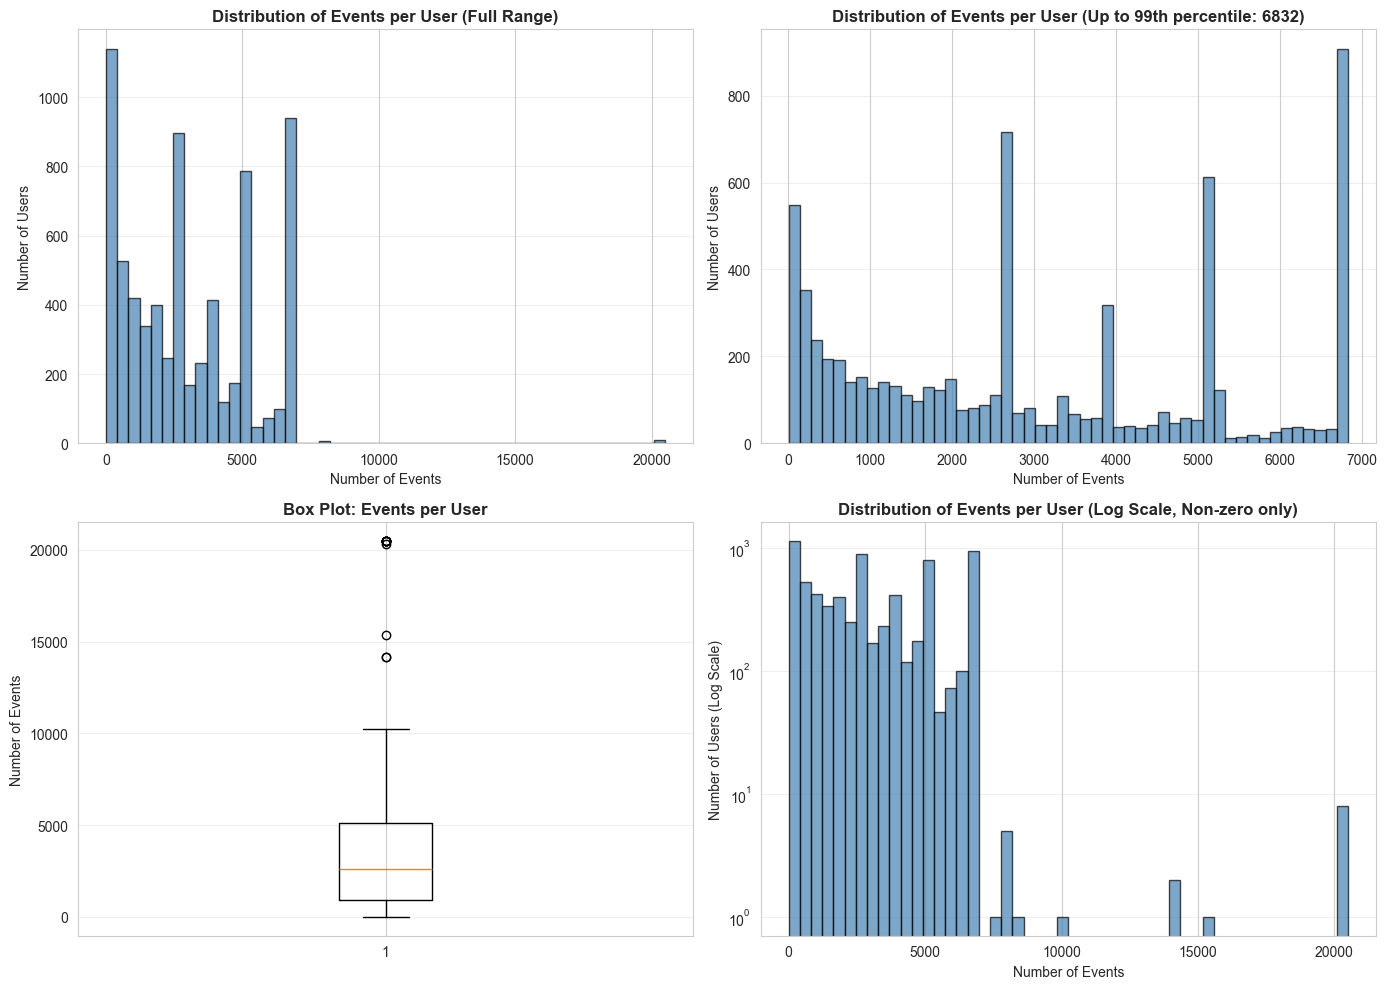

In [24]:
# Distribution of events per user
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram (full range)
axes[0, 0].hist(events_per_user['event_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Events per User (Full Range)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Events', fontsize=10)
axes[0, 0].set_ylabel('Number of Users', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Histogram (zoomed in, excluding outliers)
q99 = events_per_user['event_count'].quantile(0.99)
events_filtered = events_per_user[events_per_user['event_count'] <= q99]
axes[0, 1].hist(events_filtered['event_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Distribution of Events per User (Up to 99th percentile: {q99:.0f})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Events', fontsize=10)
axes[0, 1].set_ylabel('Number of Users', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Box plot
axes[1, 0].boxplot(events_per_user['event_count'], vert=True)
axes[1, 0].set_title('Box Plot: Events per User', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Events', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Log scale histogram (to see distribution better)
events_nonzero = events_per_user[events_per_user['event_count'] > 0]
axes[1, 1].hist(events_nonzero['event_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Distribution of Events per User (Log Scale, Non-zero only)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Events', fontsize=10)
axes[1, 1].set_ylabel('Number of Users (Log Scale)', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# Identify extremely active users
q95 = events_per_user['event_count'].quantile(0.95)
q99 = events_per_user['event_count'].quantile(0.99)

very_active = events_per_user[events_per_user['event_count'] >= q95]
extremely_active = events_per_user[events_per_user['event_count'] >= q99]

print("User Activity Levels:")
print("=" * 50)
print(f"95th percentile (very active): {q95:.0f} events")
print(f"99th percentile (extremely active): {q99:.0f} events")
print(f"\nVery active users (≥95th percentile): {len(very_active):,} ({len(very_active)/len(events_per_user)*100:.2f}%)")
print(f"Extremely active users (≥99th percentile): {len(extremely_active):,} ({len(extremely_active)/len(events_per_user)*100:.2f}%)")
print(f"\nTop 10 most active users:")
print(events_per_user.nlargest(10, 'event_count'))


User Activity Levels:
95th percentile (very active): 6832 events
99th percentile (extremely active): 6832 events

Very active users (≥95th percentile): 918 (13.05%)
Extremely active users (≥99th percentile): 918 (13.05%)

Top 10 most active users:
         user_id  event_count
499   0730-BGQGF        20498
586   0864-FVJNJ        20498
716   1053-MXTTK        20498
1655  2404-JIBFC        20498
1929  2805-EDJPQ        20498
4050  5712-AHQNN        20498
4159  5887-IKKYO        20498
3761  5302-BDJNT        20348
4737  6682-VCIXC        15373
99    0177-PXBAT        14149


In [29]:
events

,user_id,event_type,event_time,device_type,page_url,date
0,2284-VFLKH,click,2023-01-01 00:00:19,desktop,/profile,2023-01-01
1,8592-PLTMQ,watch,2023-01-01 00:00:38,mobile,/watch,2023-01-01
2,4567-AKPIA,login,2023-01-01 00:00:46,mobile,/home,2023-01-01
3,7426-GSWPO,login,2023-01-01 00:01:15,mobile,/login,2023-01-01
4,1470-PSXNM,click,2023-01-01 00:01:23,mobile,/profile,2023-01-01
...,...,...,...,...,...,...
21406791,1215-FIGMP,click,2025-12-30 22:59:06,mobile,/settings,2025-12-30
21406792,8150-QUDFX,login,2025-12-30 22:59:24,desktop,/login,2025-12-30
21406793,6542-LWGXJ,watch,2025-12-30 23:00:01,desktop,/watch,2025-12-30
21406794,4298-OYIFC,click,2025-12-30 23:00:27,tablet,/content/{id},2025-12-30


## 7. Key Observations


In [26]:
print("=" * 60)
print("KEY OBSERVATIONS")
print("=" * 60)

print("\n1. Event Summary:")
print(f"   - Total events: {len(events):,}")
print(f"   - Unique users: {events['user_id'].nunique():,}")
print(f"   - Date range: {events['event_time'].min()} to {events['event_time'].max()}")

print("\n2. Event Type Distribution:")
for event_type, count in event_type_counts.items():
    pct = event_type_pct[event_type]
    print(f"   - {event_type}: {pct:.1f}%")

print("\n3. Device Type Distribution:")
for device_type, count in device_counts.items():
    pct = device_pct[device_type]
    print(f"   - {device_type}: {pct:.1f}%")

print("\n4. User Engagement:")
print(f"   - Average events per user: {events_per_user['event_count'].mean():.1f}")
print(f"   - Median events per user: {events_per_user['event_count'].median():.0f}")
print(f"   - Users with zero events: {len(events_per_user[events_per_user['event_count'] == 0]):,}")
print(f"   - Users with 1+ events: {len(events_per_user[events_per_user['event_count'] > 0]):,}")

print("\n5. Potential Issues to Investigate:")
zero_event_users = len(events_per_user[events_per_user['event_count'] == 0])
if zero_event_users > 0:
    print(f"   - {zero_event_users:,} users have zero events (silent users)")

if len(extremely_active) > 0:
    print(f"   - {len(extremely_active):,} users are extremely active (≥{q99:.0f} events)")

print("\n" + "=" * 60)


KEY OBSERVATIONS

1. Event Summary:
   - Total events: 21,406,796
   - Unique users: 7,037
   - Date range: 2023-01-01 00:00:19 to 2025-12-30 23:01:40

2. Event Type Distribution:
   - login: 38.8%
   - watch: 36.2%
   - click: 24.1%
   - cancel: 0.9%

3. Device Type Distribution:
   - mobile: 60.1%
   - desktop: 34.3%
   - tablet: 5.1%
   - unknown: 0.5%

4. User Engagement:
   - Average events per user: 3042.0
   - Median events per user: 2628
   - Users with zero events: 0
   - Users with 1+ events: 7,037

5. Potential Issues to Investigate:
   - 918 users are extremely active (≥6832 events)

